<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Entrega 02 - Proyecto final  </center></font></h1>
<h2><font color='0B5345'> <center>
Deep Learning </center></font></h2>
<font  face="Courier New" size="3">
<p1><center> Isabella Ariza Cuberos - Luisa María Zapata Saldarriaga </center></p1>


<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia</font></b> </center></p3>

## Proyecto Deep Learning - 2024 01

Isabella Ariza Cuberos

Luisa María Zapata Saldarriaga

### **DATA**

https://www.kaggle.com/datasets/awsaf49/brats2020-training-data

El conjunto de datos seleccionado corresponde a los datos del desafío BraTS 2020 (Brain Tumor Segmentation).  

Este dataset incluye imágenes de resonancia magnética estructural de 368 sujetos, cada uno de ellos contiene 4 modalidades de imágenes:

- T1

- T2

- FLAIR

- T1ce
- Post contraste


Además, contiene las etiquetas de segmentación para cada una de las clases que conforman el tumor anotadas de la siguiente forma:


| ETIQUETA | CLASE | DESCRIPCIÓN                     |
|----------|-------|---------------------------------|
| 1        | NCR   | Núcleo del tumor necrótico      |
| 2        | ED    | Edema peritumoral               |
| 3        | ET    | Tumor realzado con gadolinio (contraste) |


Acondicionaremos los datos para que sean adecuados para el entrenamiento de la red neuronal. Dividiremos nuestro conjunto de datos en:  

- Training - 75% /80%

- Test - 15% /80%

- Validation - 20%/100%


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **STEP 1: Set up environment**

In [2]:
!pip install --upgrade pip
!pip install nilearn
!pip install seaborn
!pip install scikit-image
!pip install tensorflow
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.4 MB/s eta 0:00:00


In [3]:
# Data manipulation
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util import montage
from skimage.transform import rotate
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    4 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

Please provide the full path to your file directory.

In [ ]:
!unzip -q /content/drive/MyDrive/archive.zip

In [ ]:
TRAIN_DATASET_PATH = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

### **STEP 2: Data exploration**

Text(0.5, 1.0, 'Mask')

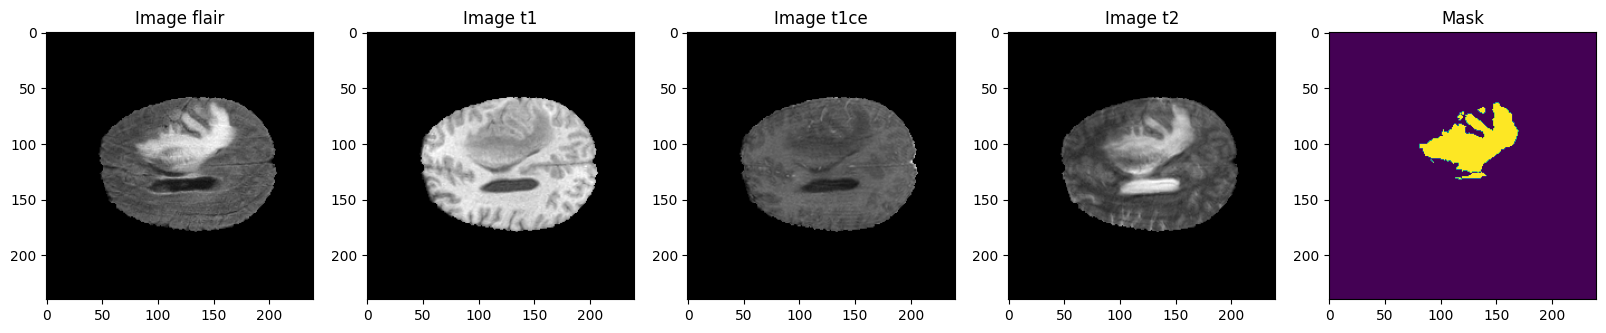

In [ ]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))

slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

### **Step 3 - Create model || U-Net** and performance metrics

- **Precisión (Accuracy)**: Mide la proporción general de píxeles clasificados correctamente, incluyendo tanto píxeles positivos como negativos.

- **Sensibilidad (Recall o Tasa de Positivos Verdaderos)**: Mide la proporción de píxeles positivos de verdad fundamental que fueron predichos correctamente como positivos.

- **Precisión (Valor Predictivo Positivo)**: Mide la proporción de píxeles positivos predichos que son realmente positivos.

- **Especificidad (Tasa de Negativos Verdaderos)**: Mide la proporción de píxeles negativos de verdad fundamental que fueron predichos correctamente como negativos.

- **Coeficiente DICE**: Evalúa la *similitud* entre la etiqueta predicha y la considerada como verdadera

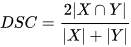

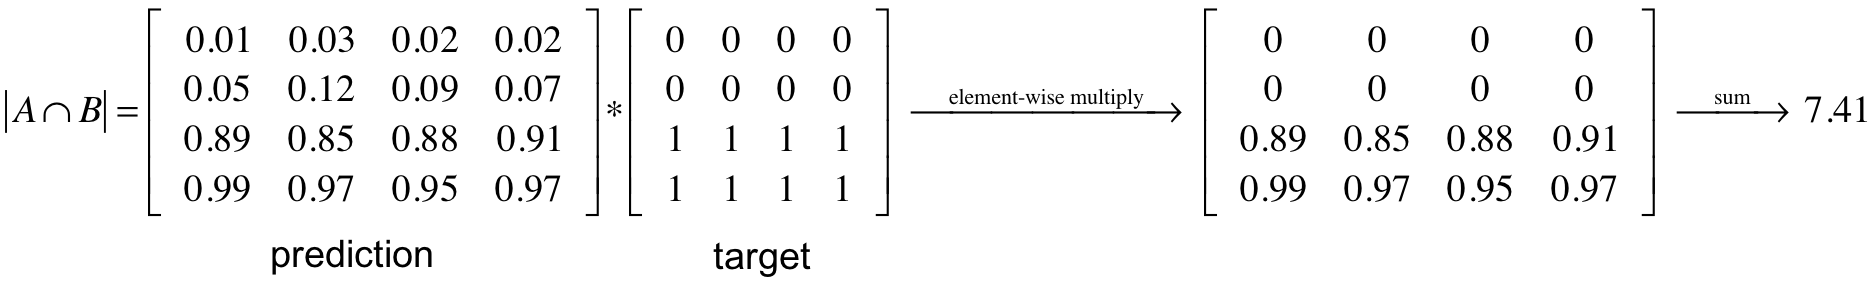

In [6]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num

    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity (True Positive Rate or Recall)
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity (True Negative Rate)
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

#### Build UNET

**Model architecture**

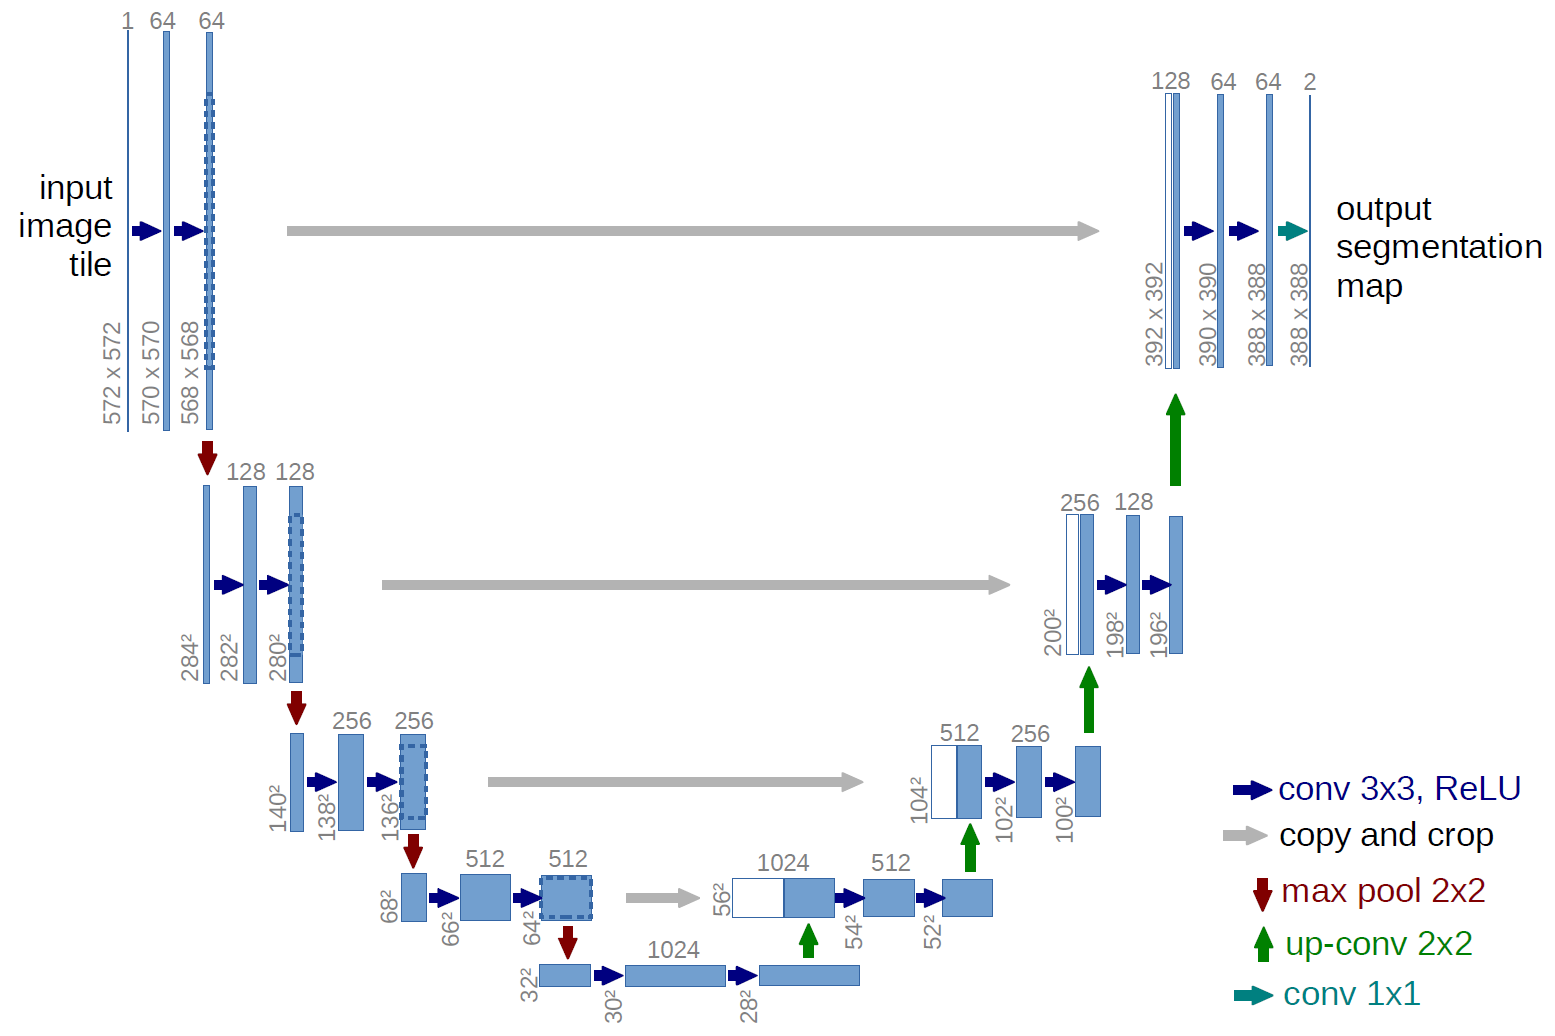

In [10]:
# Function to build the U-Net model
IMG_SIZE=128

def build_unet(inputs, ker_init, dropout):

    # First convolution block with 32 filters of size 3x3
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    # Max pooling layer to downsample the spatial dimensions by half
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Second convolution block with 64 filters of size 3x3
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)

    # Third convolution block with 128 filters of size 3x3
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Fourth convolution block with 256 filters of size 3x3
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Fifth convolution block with 512 filters of size 3x3
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)

    # Dropout layer to prevent overfitting
    drop5 = Dropout(dropout)(conv5)

    # Upsampling and concatenation to start the expansive path of U-Net
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    # Skip connections between conv3 and up7
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    # Final convolution layer with 4 filters of size 1x1 and softmax activation for multi-class segmentation
    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    # Return the U-Net model
    return Model(inputs=inputs, outputs=conv10)

# Input Layer with 1 channels
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
# Build the U-Net model
model = build_unet(input_layer, 'he_normal', 0.2)

# Compile the model with categorical crossentropy loss and various metrics
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 32)         608       ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_24[0][0]']           
 g2D)                                                                                       

### **Step 4 - Prepare data for Training**

In [ ]:
# # lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# # file BraTS20_Training_355 has ill formatted name for for seg.nii fil
train_and_val_directories.remove(TRAIN_DATASET_PATH +'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
try:
  train_and_val_directories.remove(TRAIN_DATASET_PATH +'BraTS20_Training_355')
except:
  pass
train_and_test_ids = pathListIntoIds(train_and_val_directories)


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

#### **Load data**
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators.

**Override Keras sequence DataGenerator class**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH + '', i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            # data_path = os.path.join(case_path, f'{i}_t1.nii');
            # t1 = nib.load(data_path).get_fdata()

            # data_path = os.path.join(case_path, f'{i}_t2.nii');
            # t2 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                #  X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                #  X[j +VOLUME_SLICES*c,:,:,3] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


**Number of data used**
for training / testing / validation

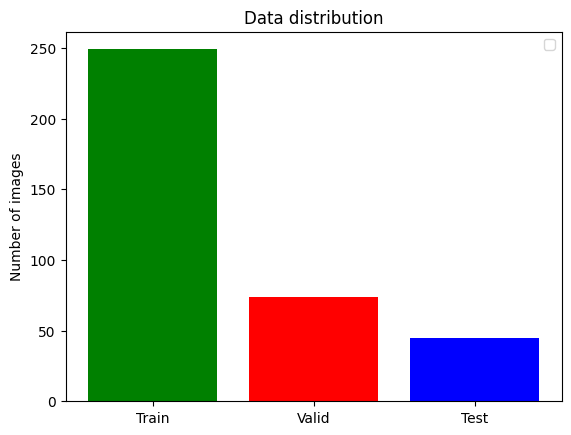

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    # plt.bar(["Train","Valid"],
    # [len(train_ids), len(val_ids)], align='center',color=[ 'green','red'])
    # plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

249
74
45


**Add callback for training process**

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    CSVLogger('training_t1_paper.log', separator=',', append=False)
]

### **Step 5 - Train the model**

| Hiperparámetros/ Iteraciones       | 1                              | 2                                 | 3                              | 4                              |
|-----------------------|--------------------------------|-----------------------------------|--------------------------------|--------------------------------|
| Número de épocas      | 50                             | 35                                | 35                             | 35                             |
| Optimizador           | Adam                           | Adam                              | Adam                           | Adam                           |
| Batch size            | 1                              | 32                                | 16                             | 1                              |
| Función de pérdida    | Categorical Cross-Entropy      | Categorical Cross-Entropy         | Categorical Cross-Entropy      | Categorical Cross-Entropy      |
| Callbacks             | Early stopping                 | Early stopping, Model Checkpoint  | Early stopping                 | Early stopping                 |
| Tipo de datos         | T1ce y FLAIR                   | T1                                | T1ce y FLAIR                   | T1                             |


In [ ]:
history = model.fit(training_generator,
          epochs=50,
          steps_per_epoch=len(train_ids),
          callbacks=callbacks,
          validation_data=valid_generator)
model.save("model_all_1_50.h5")

from google.colab import files

files.download("model_all_1_50.h5")
files.download("training_all_1_50.log")

Epoch 1/50
249/249 [==============================] - 326s 1s/step - loss: 0.1178 - accuracy: 0.9795 - dice_coef: 0.2749 - precision: 0.9800 - sensitivity: 0.9741 - specificity: 0.9947 - dice_coef_necrotic: 0.0735 - dice_coef_edema: 0.1534 - dice_coef_enhancing: 0.0637 - val_loss: 0.0842 - val_accuracy: 0.9830 - val_dice_coef: 0.2798 - val_precision: 0.9829 - val_sensitivity: 0.9822 - val_specificity: 0.9943 - val_dice_coef_necrotic: 0.0825 - val_dice_coef_edema: 0.2330 - val_dice_coef_enhancing: 0.0733
Epoch 2/50
249/249 [==============================] - 245s 984ms/step - loss: 0.0702 - accuracy: 0.9830 - dice_coef: 0.2803 - precision: 0.9834 - sensitivity: 0.9828 - specificity: 0.9945 - dice_coef_necrotic: 0.0738 - dice_coef_edema: 0.1592 - dice_coef_enhancing: 0.0689 - val_loss: 0.0660 - val_accuracy: 0.9831 - val_dice_coef: 0.3019 - val_precision: 0.9859 - val_sensitivity: 0.9793 - val_specificity: 0.9953 - val_dice_coef_necrotic: 0.1099 - val_dice_coef_edema: 0.2122 - val_dice_co

**Visualize the training process**

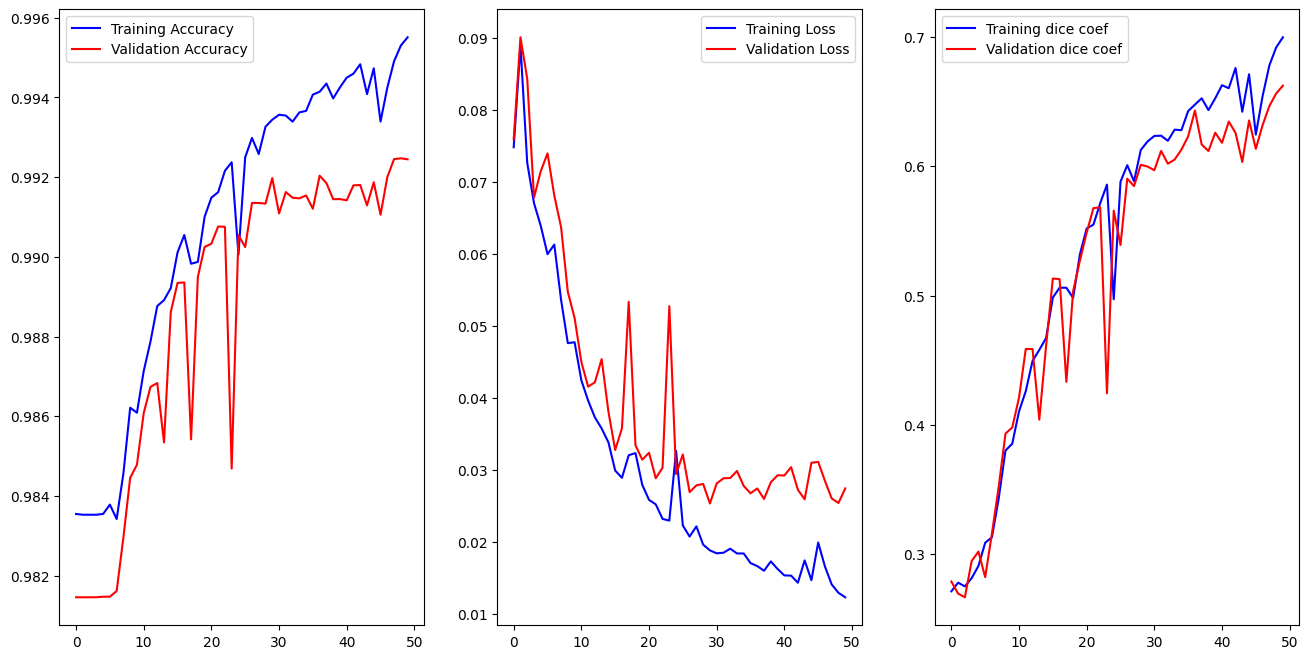

In [13]:
############ load trained model ################
model = keras.models.load_model('/content/drive/MyDrive/model_x1_2_50_1_p(1).h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=2),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/training(2).log_p', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

plt.show()

### **Step 6 - Predict tumor segmentations**

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


### **Step 7 - Evaluate the model**

4/4 [==============================] - 1s 66ms/step


<Figure size 1800x5000 with 0 Axes>

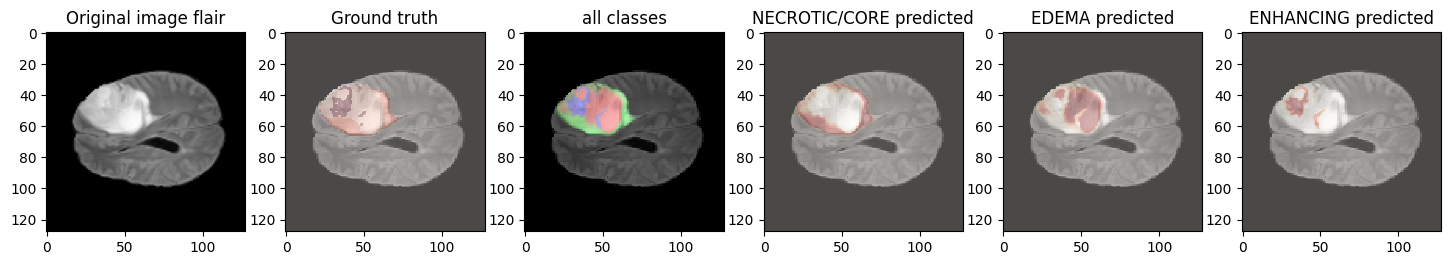

4/4 [==============================] - 1s 68ms/step


<Figure size 1800x5000 with 0 Axes>

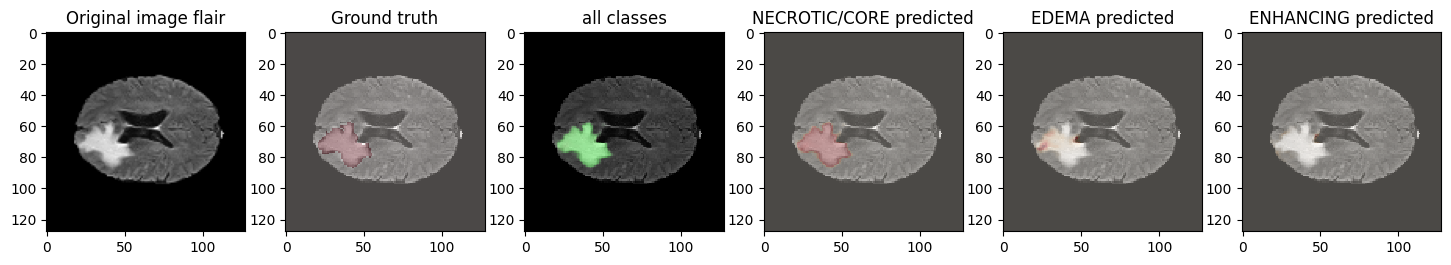

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

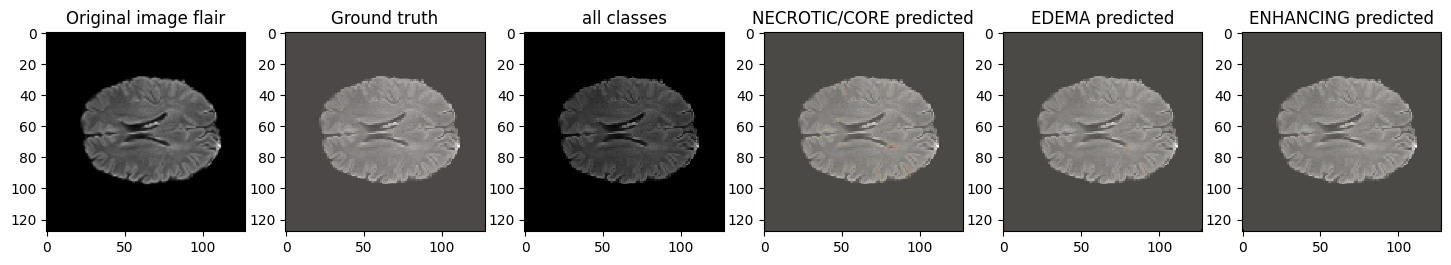

4/4 [==============================] - 0s 68ms/step


<Figure size 1800x5000 with 0 Axes>

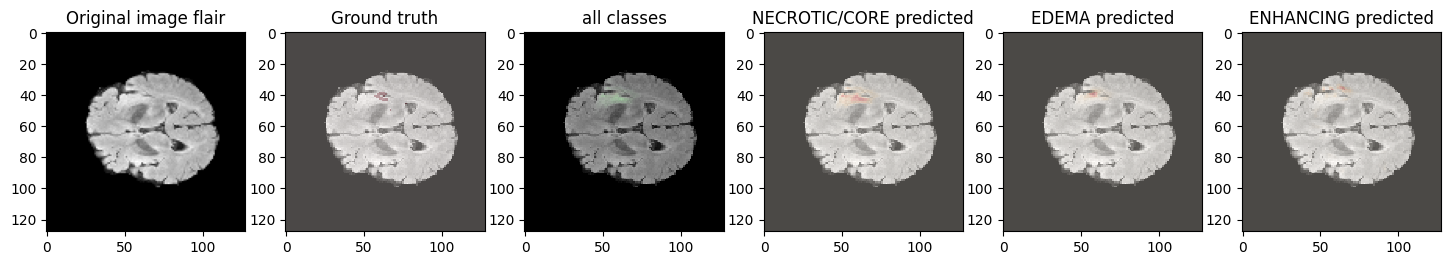

4/4 [==============================] - 0s 44ms/step


<Figure size 1800x5000 with 0 Axes>

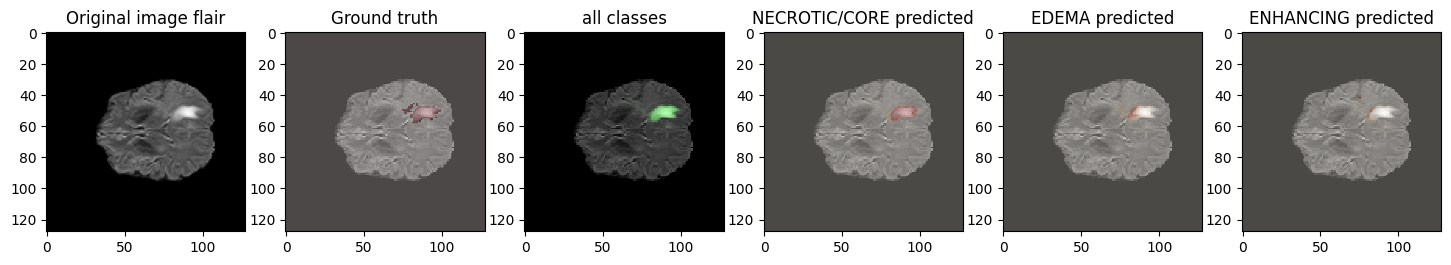

4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

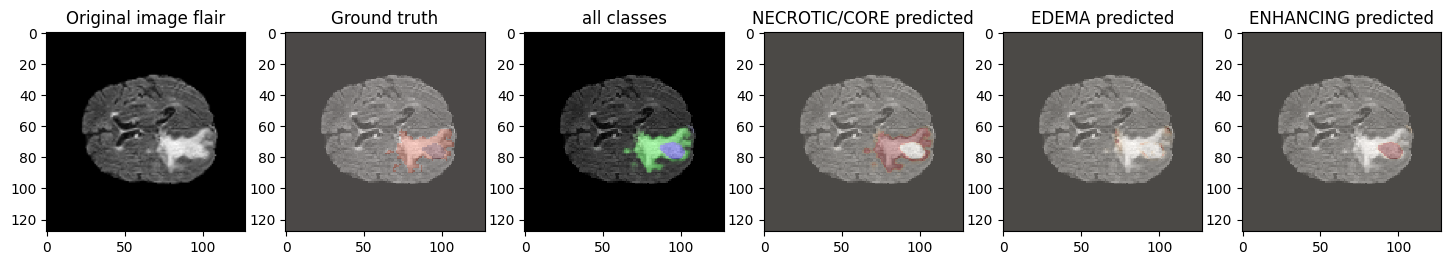

4/4 [==============================] - 0s 43ms/step


<Figure size 1800x5000 with 0 Axes>

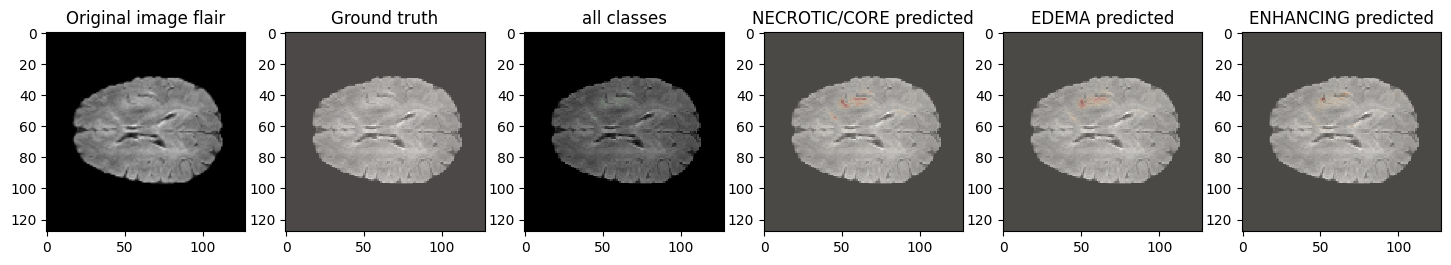

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[4]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])
